In [2]:
import os
import sys

In [3]:
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')

In [4]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [86]:
c2p = Cell2PointsConverter(orders=[[3],[3,3]])

In [92]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [93]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(unrisky=True), method='sympy')

Number of equations: 11
Number of degrees of freedom: 28
Strictly stitched_power: 0
Start solving strict part
End solving strict part
NullspaceRank: 18


In [94]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [95]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=True),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [ ]:
opt_solve.fit_opt(constraints=True, tr_fun_option='polynomial', orders_forwards=1)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [48]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [51]:
tr_f = np.vectorize(lambda x: x**2)

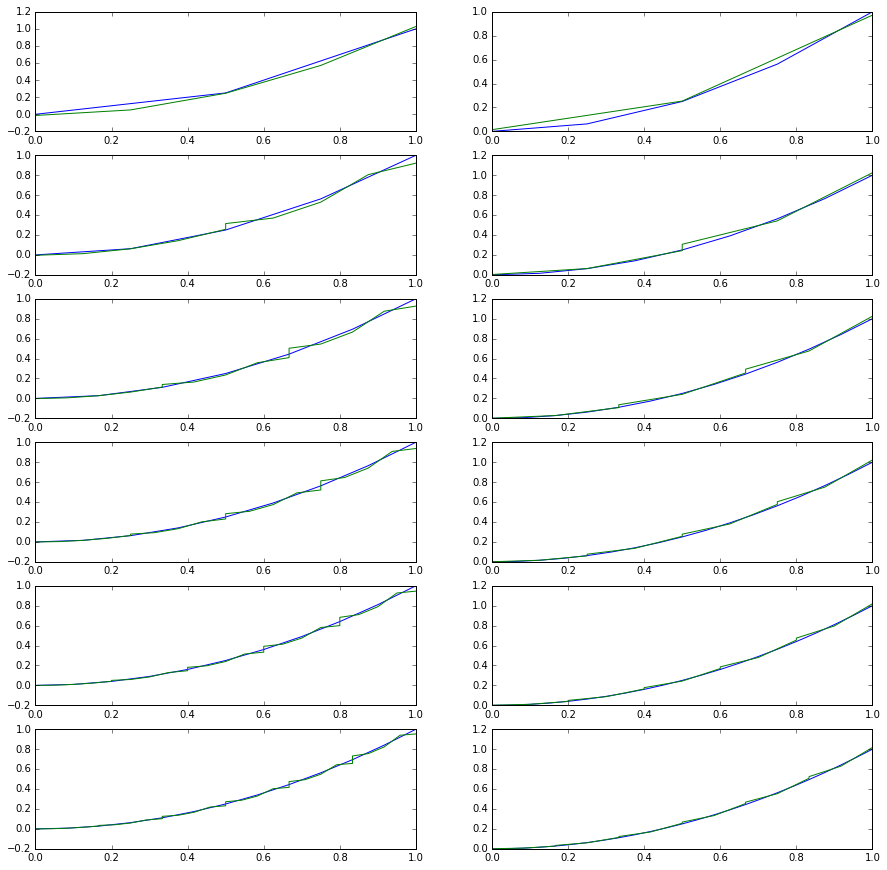

In [52]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [47]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

array([  1.00000000e+00,   9.97656450e-01,   9.98902633e-01,
        -9.35595776e-18,  -9.15603394e-17])

In [54]:
I_lr

array([[ 0.56444244,  0.59927037, -0.16371281],
       [ 0.45760562,  0.65494549, -0.1125511 ],
       [ 0.18325773,  0.76035615,  0.05638612],
       [-0.33350777,  1.01532462,  0.31818315],
       [ 0.5726507 , -0.80106311,  1.2284124 ]])

In [68]:
I_rl

array([[ 0.28222122,  0.91521123,  0.18325773, -0.66701554,  0.28632535],
       [ 0.0749088 ,  0.32747274,  0.19008904,  0.50766231, -0.10013289],
       [-0.08185641, -0.22510221,  0.05638612,  0.63636629,  0.6142062 ]])

In [72]:
np.dot(I_lr, c2p.get_weights()[0]).sum()

1.9477501546063372

In [75]:
c2p.get_weights()[0]

array([ 0.16666667,  0.66666669,  0.16666667])

In [76]:
np.dot(I_rl, c2p.get_weights()[1]).sum()

0.65945980305632568

In [83]:
np.dot(np.dot(c2p.get_diag_weights()[1], I_lr), np.linalg.inv(c2p.get_diag_weights()[0]))

array([[ 0.28222122,  0.0749088 , -0.08185641],
       [ 0.91521123,  0.32747274, -0.22510221],
       [ 0.18325773,  0.19008904,  0.05638612],
       [-0.66701554,  0.50766231,  0.63636629],
       [ 0.28632535, -0.10013289,  0.6142062 ]])

In [85]:
I_rl.T

array([[ 0.28222122,  0.0749088 , -0.08185641],
       [ 0.91521123,  0.32747274, -0.22510221],
       [ 0.18325773,  0.19008904,  0.05638612],
       [-0.66701554,  0.50766231,  0.63636629],
       [ 0.28632535, -0.10013289,  0.6142062 ]])